In [ ]:
!pip install import_ipynb

In [ ]:
import import_ipynb
%run /content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/unet.ipynb
%run /content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/UpdatedMeanIoU.ipynb
#import unet
#from unet import build_unet

In [ ]:
#from unet import build_unet
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import MeanIoU
from keras.callbacks import EarlyStopping

In [ ]:

train_frame_list = os.listdir("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/train_frame/frame")
train_frame_list = sorted(train_frame_list)
print(train_frame_list)
print(len(train_frame_list))

train_mask_list = os.listdir("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/train_mask/mask")
train_mask_list = sorted(train_mask_list)
print(train_mask_list)
print(len(train_mask_list))

for frame, mask in zip(train_frame_list, train_mask_list):
  frame = frame.split(".")
  mask = mask.split(".")
  if frame[0]!=mask[0]:
    print(frame[0], mask[0])
    break

In [ ]:
'''
file_path = "/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/train_mask/mask/video_03_000009000 (1).png"
# Check if the file exists before attempting to delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"The file {file_path} has been deleted.")
else:
    print(f"The file {file_path} does not exist.")
'''

In [ ]:

val_frame_list = os.listdir("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/val_frame/frame")
val_frame_list = sorted(val_frame_list)
print(val_frame_list)
print(len(val_frame_list))

val_mask_list = os.listdir("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/val_mask/mask")
val_mask_list = sorted(val_mask_list)
print(val_mask_list)
print(len(val_mask_list))

for frame, mask in zip(val_frame_list, val_mask_list):
  frame = frame.split(".")
  mask = mask.split(".")
  if frame[0]!=mask[0]:
    print(frame[0], mask[0])


In [ ]:
'''
file_path = "/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/val_frame/frame/video_38_12900.jpg"
# Check if the file exists before attempting to delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"The file {file_path} has been deleted.")
else:
    print(f"The file {file_path} does not exist.")
'''

In [ ]:

test_frame_list = os.listdir("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/test_frame/frame")
test_frame_list = sorted(test_frame_list)
print(test_frame_list)
print(len(test_frame_list))

test_mask_list = os.listdir("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/test_mask/mask")
test_mask_list = sorted(test_mask_list)
print(test_mask_list)
print(len(test_mask_list))

for frame, mask in zip(test_frame_list, test_mask_list):
  frame = frame.split(".")
  mask = mask.split(".")
  if frame[0]!=mask[0]:
    print(frame[0], mask[0])


In [ ]:
'''
file_path = "/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/test_frame/frame/video_38_12900.jpg"
# Check if the file exists before attempting to delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"The file {file_path} has been deleted.")
else:
    print(f"The file {file_path} does not exist.")
'''

In [ ]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
batch_size= 8
n_classes= 9

In [ ]:
img_data_gen_args = dict(rescale = 1/255., #Original pixel values are 0 and 255. So rescaling to 0 to 1
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

In [ ]:
#If You need to resize images then add this to the flow_from_directory parameters
#target_size=(150, 150), #Or whatever the size is for your network

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/train_frame/",
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays
                                                                            #thinking class mode is binary.

mask_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/train_mask/",
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/val_frame/",
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/val_mask/",
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here




Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [ ]:
train_generator = zip(image_generator,mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

for i in train_generator:
  print(i[0].shape)
  print(i[1].shape)
  break

for i in val_generator:
  print(i[0].shape)
  print(i[1].shape)
  break

(8, 256, 256, 3)
(8, 256, 256, 1)
(8, 256, 256, 3)
(8, 256, 256, 1)


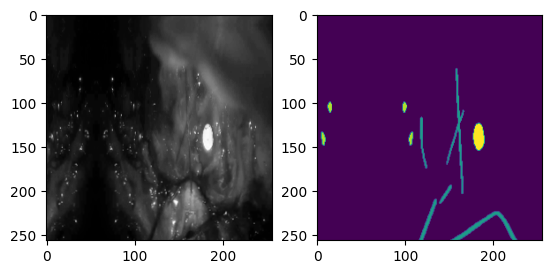

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
from keras import backend as K

#Dice metric can be a great metric to track accuracy of semantic segmentation.
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0

    return 2*intersection / union


In [ ]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

256 256 3


In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
model = build_unet(input_shape)

In [ ]:
mIOU = UpdatedMeanIoU(num_classes=9)
model.compile(optimizer=Adam(lr = 1e-3), loss='categorical_crossentropy', metrics=[mIOU, dice_metric])
#model.compile(optimizer=Adam(lr = 1e-3), loss='categorical_crossentropy', metrics=[dice_metric])

model.summary()

In [ ]:
num_train_imgs = len(os.listdir('/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/train_frame/frame/'))
num_train_mask = len(os.listdir('/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/train_mask/mask/'))
print(num_train_imgs, num_train_mask)
steps_per_epoch = num_train_imgs //batch_size
print(steps_per_epoch)

200 200
25


In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=20, verbose=1, restore_best_weights=True,)

history=model.fit(train_generator, validation_data=val_generator, steps_per_epoch=steps_per_epoch,
                  validation_steps=steps_per_epoch, epochs=5,  callbacks=[early_stopping],)

Epoch 1/5
25/25 [==============================] - 1958s 78s/step - loss: 0.0544 - updated_mean_io_u: 0.0272 - dice_metric: 0.0051 - val_loss: 0.9949 - val_updated_mean_io_u: 0.0711 - val_dice_metric: 0.0017
Epoch 2/5
25/25 [==============================] - 1993s 80s/step - loss: 0.0549 - updated_mean_io_u: 0.0100 - dice_metric: 0.0053 - val_loss: 0.2193 - val_updated_mean_io_u: 0.0022 - val_dice_metric: 0.0016
Epoch 3/5
25/25 [==============================] - ETA: 0s - loss: 0.0544 - updated_mean_io_u: 4.3436e-04 - dice_metric: 0.0053  

In [ ]:
#model.save('semanticSegmentation_50epochs.hdf5')
#model = tf.keras.models.load_model("semanticSegmentation_50epochs.hdf5", compile=False)

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
test_img_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/test_frame/",
                                                              seed=seed,
                                                              batch_size=32,
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/ColabNotebooks/Sementatic_Segmentation/dataset_small/test_mask/",
                                                              seed=seed,
                                                              batch_size=32,
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here
test_generator = zip(test_img_generator, test_mask_generator)

In [ ]:
print(test_img_generator[0].shape)
num_test_imgs = len(test_img_generator[0])

print(num_test_imgs)
batch_size = 16

steps_per_epoch = num_test_imgs //batch_size
print(steps_per_epoch)
#for frame, mask in test_generator:
_, dice_metric, mIOU = model.evaluate(test_generator, steps=steps_per_epoch)
print("Dice metric is = ", (dice_metric * 100.0), "%", "mIOU is = ", (mIOU * 100.0), "%")